Trying to identify station locations from a game frame using a station "sprite", created by cropping the original game frame and adding a transparent background

In [90]:
import numpy as np
import skimage.io
from skimage.feature import match_template
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import islice
from scipy.signal import fftconvolve

%matplotlib inline

sprite_path = '../plugins/SerpentMiniMetroGamePlugin/files/data/sprites/sprite_station_square_0.png'
frame_path = '../datasets/test/frame_1532378861.391295.png'

In [91]:
frame_img = skimage.io.imread(frame_path)
sprite_img = skimage.io.imread(sprite_path) 

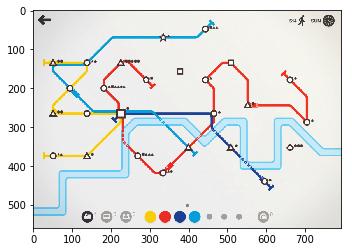

In [92]:
plt.imshow(frame_img)

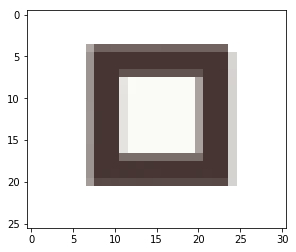

In [93]:
plt.imshow(sprite_img)

In [94]:
print('frame', frame_img.shape)
print('sprite', sprite_img.shape) # alpha channel present

frame (560, 794, 3)
sprite (26, 31, 4)


`match_template` requires target and template images to have same number of channels, we will remove the alpha channel from the sprite

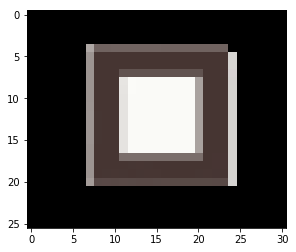

In [101]:
image = frame_img
template = sprite_img[...,:3] # removing alpha

plt.imshow(template)

By removing transparency our black "margin" is now visible.

Run template matching

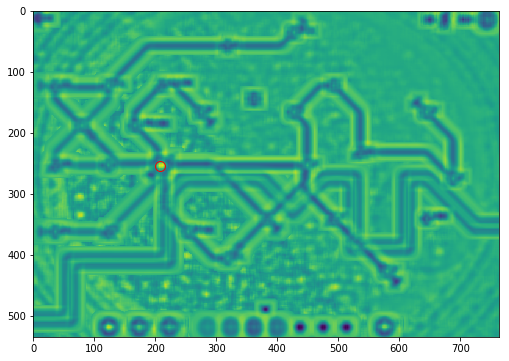

In [98]:
matches = match_template(image, template).squeeze()
# get coordinates of top match
y, x = np.unravel_index(np.argmax(matches), matches.shape)

fig, ax = plt.subplots(figsize=(20, 6))
ax.imshow(matches)
# highlight region of top match
ax.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

Check our top match

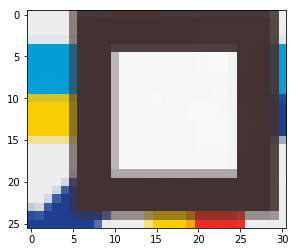

In [99]:
plt.imshow(image[y:y+template.shape[0], x:x+template.shape[1]])

We have found a square station but not the one we were hoping for, it is actually an interchange (with a thicker border). This poor match will be due to our target also containing (black margin) values we do not want to match to. We will see if we can match with or original station by replacing the black margin with white, as this will be a better estimation of the original station.

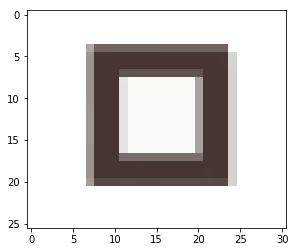

In [102]:
image = frame_img
template[sprite_img[:,:,3] == 0] = np.array([255,255,255]) # removing alpha and replacing black with white

plt.imshow(template)

Run template matching

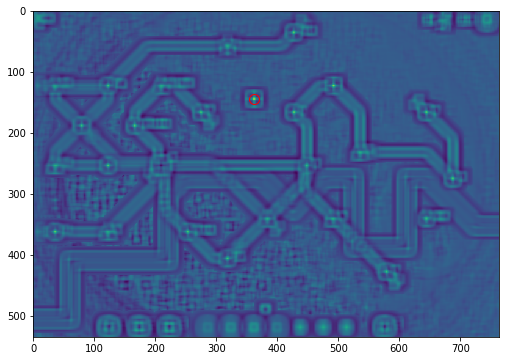

In [103]:
matches = match_template(image, template).squeeze()
# get coordinates of top match
y, x = np.unravel_index(np.argmax(matches), matches.shape)

fig, ax = plt.subplots(figsize=(20, 6))
ax.imshow(matches)
# highlight region of top match
ax.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

Check our top match

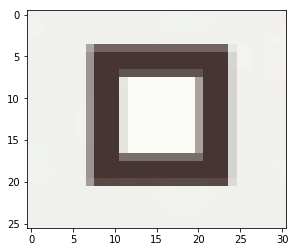

In [104]:
plt.imshow(image[y:y+template.shape[0], x:x+template.shape[1]])

We now get our top match as the original station, checking top 50 matches

In [79]:
# TODO: Refactor methods into a class as there are a lot of repeated parameters
# also there is inconsistency in the "generic" definition of top_indices whilst the other methods

def top_indices(array, n):
    """ Return i,j indices of top n values in a 2d array """
    
    # get sorted (flattened) indices 
    flattened_indices = np.argsort(array, axis=None)[:n:-1]
    
    # convert flattened indices to separate lists of i and j indices 
    ij_indices = np.unravel_index(flattened_indices, array.shape) 
    
    # zip index pairs into an iterator of i,j tuples 
    return zip(*ij_indices) 


def dedupe_indices(indices, matches, template):
    """ Singularise indices by only yielding one match from each overlapping region """
    
    dedupe_mask = np.full(matches.shape, False)
    
    for i, j in indices:
        match_mask = np.full(matches.shape, False)
        match_mask[i:i+template.shape[0], j:j+template.shape[1]] = True
        
        # check if match mask overlaps with global dedupe mask containing cumulative matches
        if (dedupe_mask * match_mask).any() == False:
            yield (i, j)
            
        dedupe_mask[i:i+template.shape[0], j:j+template.shape[1]] = True


def plot_top_matches(matches, image, template, n=50, dedupe=False):
    """ Plot matches with the largest correlation coefficient, optionally singularize overlapping matches 
    :param matches: 2d array containing correlation coefficent at i,j location
    :param image: reference image uses in matching
    :param template: template used in matching
    :param n: number of matches to plot
    :param dedupe: only show one match from each overlapping set
    """

    dedupe_mask = np.full(matches.shape, False)
    
    _, axes = plt.subplots(nrows=5,ncols=10, figsize=(15,7), sharex=True, sharey=True)
    
    # return top indices from matches and optionally singularize
    indices = top_indices(matches, n=n)
    if dedupe:
        indices = dedupe_indices(indices, matches, template)
    
    # iterate through top matches and plot
    for ax, (i, j) in zip(axes.flat, indices):
        ax.imshow(image[i:i+template.shape[0], j:j+template.shape[1]])
        
        # add title containing co-ordinates and magnitude of match
        ax.set_title('{},{} ({:.2f})'.format(i,j,result.squeeze()[i,j]), fontsize=8)

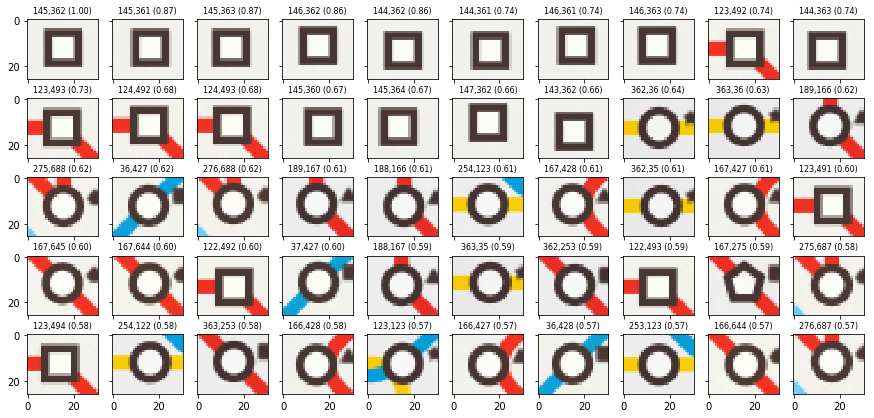

In [105]:
plot_top_matches(matches, image, template)

Top matches contain multiple matches for the same station, remove duplicates

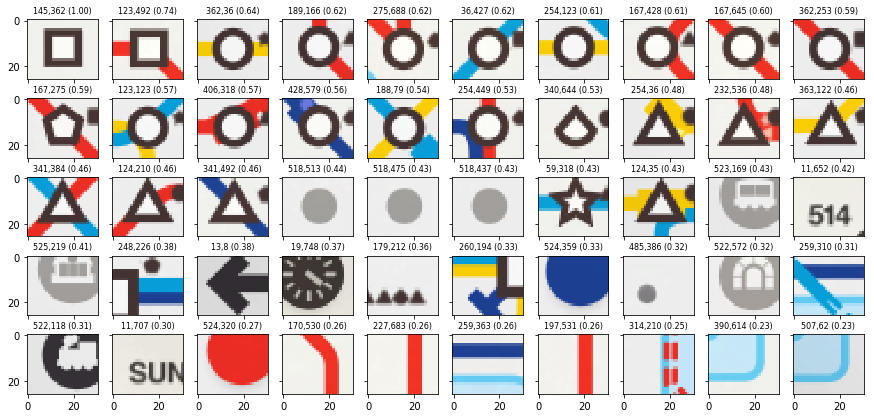

In [106]:
plot_top_matches(matches, image, template, dedupe=True)

Most of the top matches are stations, but we still see a few non stations. This is still caused by the fact that our template has a significant "margin" which is included in the correlation calculation. We could crop our template to fix the square case but then would still have this issue on triangle and circle stations etc.

What we need is a way of calculating the correlation which excludes the margin (originally transparent with an alpha value of 255). 
Note this can **not** simply be achieved by setting these values to zero (which is actually what we had in our first example) as we are doing zero-mean adjustment in the template-matching [confirm this] so the zero values going into the calculation will not be zero in the actual calculation)